## Connecting our Research Question to Data

***Does the appearance of JHU in the movies affect application rates?***

What data will we need to answer this question?

- List of JHU appearances in film
    - Year of appearance
    - Characteristics of the movie - genre, rating, etc.
- JHU application rates
    - Year of the application rate

## Finding and accessing the data we need 

This is usually the hard part, but as a Love Data Week present we've pre-prepared a set of files that can help us answer our research question ❤️

- **`jhu-titles.csv`**: Titles and Years of titles featuring, or filmed at, JHU, scraped from [Johns Hopkins on Film](https://hub.jhu.edu/2015/10/13/johns-hopkins-on-film/)
- **`imdb-title-basics.csv`**: A truncated version of `title.basics.tsv` from [IMDb Datasets](https://datasets.imdbws.com/) including 26 titles that match the Title/Year combination from `jhu-titles.csv`
- **`imdb-ratings.csv`**: The original `title.ratings.tsv` from [IMDb Datasets](https://datasets.imdbws.com/), exported as a .csv
- **`IPEDS_Raw`**: folder of 20 files, each containing JHU application and acceptance data from one year 2001 - 2020, downloaded from [IPEDS](https://nces.ed.gov/ipeds) (Integrated Postsecondary Education Data System)

## Data cleaning considerations

While we have pre-prepared files that we can use to answer our research question, they are not 100% ready. We do have some data considerations to think about before our data will be ready to answer our research question:

- There are often more than one match in `imdb-title-basics.csv` to the titles listed in `jhu-titles.csv`, so we will have to be careful to ensure we are selecting the right title.
- Titles are not always consistent, for example **The Curve (1998)** has the original title **Dead Man's Curve**, so we will need to be careful with our titles during analysis.
-  Both `imdb-title-basics.csv` and `jhu-titles.csv` have fields with year information, which we will need to ensure is treated as a date, and not an as arbirtrary numeric value.
- Finally, we have data spread across many many files! We have a little bit of work ahead of us to ensure these are combined in a way that makes them meaningful and useful.

## Preparing Acceptance Rate Data

Prior to the workshop, we downloaded data on applications and acceptances from IPEDS. 

Let's go over to the [IPEDS Custom Data File page](https://nces.ed.gov/ipeds/datacenter/InstitutionByName.aspx?goToReportId=5&sid=506bb19e-f71f-4863-b838-95a0b656aebf&rtid=5) and walk through the process.

Key takeaways:
- Our earliest JHU film appearance is 1946,  but we found out that acceptance data is only available from 2001 on, so we'll have to filter out films from prior to 2000 when plotting the data.
- Each year downloaded as a separate file. Looks like we'll have to find a way to combine them.

Let's take a look at a couple of the files we downloaded.

We'll be using the a Python library called `pandas` to read and prepare this data - to read in a csv to a spreadsheet-like structure called a DataFrame, we'll use the `pandas` function [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [1]:
import pandas as pd 
pd.read_csv("IPEDS_Raw/CSV_192026-1007.csv").head()

,unitid,institution name,year,ADM2015_RV.Applicants total,ADM2015_RV.Applicants men,ADM2015_RV.Applicants women,ADM2015_RV.Admissions total,ADM2015_RV.Admissions men,ADM2015_RV.Admissions women,ADM2015_RV.Enrolled total,ADM2015_RV.Enrolled men,ADM2015_RV.Enrolled women,ADM2015_RV.Enrolled full time total,ADM2015_RV.Enrolled full time men,ADM2015_RV.Enrolled full time women,ADM2015_RV.Enrolled part time total,ADM2015_RV.Enrolled part time men,ADM2015_RV.Enrolled part time women
0,162928,Johns Hopkins University,2015,25474,12409,13065,3597,1781,1816,1368,684,684,1368,684,684,NaN,NaN,NaN


In [2]:
pd.read_csv("IPEDS_Raw/CSV_192026-1030.csv").head()

,unitid,institution name,year,ADM2019_RV.Applicants total,ADM2019_RV.Applicants men,ADM2019_RV.Applicants women,ADM2019_RV.Admissions total,ADM2019_RV.Admissions men,ADM2019_RV.Admissions women,ADM2019_RV.Enrolled total,ADM2019_RV.Enrolled men,ADM2019_RV.Enrolled women,ADM2019_RV.Enrolled full time total,ADM2019_RV.Enrolled full time men,ADM2019_RV.Enrolled full time women,ADM2019_RV.Enrolled part time total,ADM2019_RV.Enrolled part time men,ADM2019_RV.Enrolled part time women
0,162928,Johns Hopkins University,2019,31139,14413,16726,3477,1603,1874,1475,706,769,1475,706,769,NaN,NaN,NaN


We can see that each csv has a single row representing a single year, and the variables we downloaded from IPEDs. But the variable names have different prefixes in each file - we'll have to address this when combining them.

## Combining IPEDS files

To combine our files, we'll use the [`concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) function from pandas, which allows us to append either columns or rows from one DataFrame to another. The axis argument determines whether we 'stack' two DataFrames on top of each other or side by side.

axis=0 refers to the rows of the DataFrames, and tells pandas to stack the DataFrames vertically. axis=1 refers to the columns of the DataFrames and tells pandas to stack the DataFrames horizontally.

Because we want to stack vertically, we need to make sure the two DataFrames have the same columns and respective data types.

Before we can use `concat()`, we need to read all our files into dataframes. As we saw above, to use `read_csv()` we need the path to the file. While  we could copy these out manually, Python has a method called `glob()` for listing the contents of a given directory.

In [3]:
import glob
import os

# Define the directory path where your CSV files are located. Use a relative path (e.g., './my_csv_files') or an absolute path
directory_path = './IPEDS_Raw'

# Get a list of all CSV files in the directory. The pattern '*.csv' matches all files ending with .csv
ipeds_files = glob.glob(os.path.join(directory_path, '*.csv'))
print(ipeds_files)

['./IPEDS_Raw/CSV_192026-1007.csv', './IPEDS_Raw/CSV_192026-313.csv', './IPEDS_Raw/CSV_192026-517.csv', './IPEDS_Raw/CSV_192026-996.csv', './IPEDS_Raw/CSV_192026-405.csv', './IPEDS_Raw/CSV_192026-200.csv', './IPEDS_Raw/CSV_192026-990.csv', './IPEDS_Raw/CSV_192026-417.csv', './IPEDS_Raw/CSV_192026-789.csv', './IPEDS_Raw/CSV_192026-158.csv', './IPEDS_Raw/CSV_192026-432.csv', './IPEDS_Raw/CSV_192026-191.csv', './IPEDS_Raw/CSV_192026-620.csv', './IPEDS_Raw/CSV_192026-178.csv', './IPEDS_Raw/CSV_192026-1030.csv', './IPEDS_Raw/CSV_192026-65.csv', './IPEDS_Raw/CSV_192026-253.csv', './IPEDS_Raw/CSV_192026-737.csv', './IPEDS_Raw/CSV_192026-293.csv', './IPEDS_Raw/CSV_192026-668.csv']


Now, we can loop through all of the files in the directory we designated above and read each in as a pandas dataframe.
To make sure each dataframe has the same column names, we'll use the `header` and `names` arguments of `read_csv()` to set standard column names manually as we read each file in.
Then, we'll use `concat()` to combine all of the dataframes together into a dataframe called `combined_df`

In [4]:
# Create a empty dataframe to insert the data from our csvs into
ipeds_df = pd.DataFrame()

for file in ipeds_files:
    df = pd.read_csv(file, header = 0, names = ['id', 'institution', 'year', 'applicants_total', 'applicants_men', 'applicants_women',
                                                'admissions_total', 'admissions_men', 'admissions_women', 'enrolled_total', 'enrolled_men',
                                                'enrolled_women', 'enrolled_ft_total', 'enrolled_ft_men', 'enrolled_ft_women',
                                                'enrolled_pt_total', 'enrolled_pt_men', 'enrolled_pt_women'])
    ipeds_df = pd.concat([df, ipeds_df], ignore_index=True)
ipeds_df.head(20)

,id,institution,year,applicants_total,applicants_men,applicants_women,admissions_total,admissions_men,admissions_women,enrolled_total,enrolled_men,enrolled_women,enrolled_ft_total,enrolled_ft_men,enrolled_ft_women,enrolled_pt_total,enrolled_pt_men,enrolled_pt_women
0,162928,Johns Hopkins University,2001,9129,4862,4267,3132,1778,1354,1015,609,406,1015,609,406,0.0,0.0,0.0
1,162928,Johns Hopkins University,2010,18735,9696,9039,4169,2141,2028,1325,679,646,1325,679,646,0.0,0.0,0.0
2,162928,Johns Hopkins University,2003,10023,5299,4724,3067,1650,1417,1041,576,465,1041,576,465,NaN,NaN,NaN
3,162928,Johns Hopkins University,2007,16503,8307,8196,4243,2201,2042,1263,655,608,1263,655,608,0.0,0.0,0.0
4,162928,Johns Hopkins University,2004,11763,6256,5507,3613,1846,1767,1128,603,525,1128,603,525,0.0,0.0,0.0
5,162928,Johns Hopkins University,2019,31139,14413,16726,3477,1603,1874,1475,706,769,1475,706,769,NaN,NaN,NaN
6,162928,Johns Hopkins University,2005,11973,6147,5826,4201,2162,2039,1229,642,587,1229,642,587,0.0,0.0,0.0
7,162928,Johns Hopkins University,2013,21336,10630,10706,3869,1958,1911,1390,700,690,1390,700,690,0.0,0.0,0.0
8,162928,Johns Hopkins University,2017,27156,12732,14424,3405,1625,1780,1420,694,726,1420,694,726,NaN,NaN,NaN
9,162928,Johns Hopkins University,2018,29776,13610,16166,3417,1603,1814,1420,655,758,1420,655,758,NaN,NaN,NaN


## Planning our data preparation

Now that all our data is in one place, let's recall our goal: to generate a table with acceptance rate by year. We can use the pandas function [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) to generate a quick summary of our data to see if we want to add anything else.

In [5]:
ipeds_df.describe()

,id,year,applicants_total,applicants_men,applicants_women,admissions_total,admissions_men,admissions_women,enrolled_total,enrolled_men,enrolled_women,enrolled_ft_total,enrolled_ft_men,enrolled_ft_women,enrolled_pt_total,enrolled_pt_men,enrolled_pt_women
count,20.0,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000,20.000000,20.000000,20.000000,20.000000,20.000000,13.000000,13.0,13.000000
mean,162928.0,2010.50000,19711.90000,9698.000000,10013.850000,3758.500000,1901.700000,1856.800000,1312.350,672.900000,639.100000,1312.250000,672.900000,639.000000,0.153846,0.0,0.153846
std,0.0,5.91608,7338.20477,3200.630415,4157.418129,451.533119,258.210053,227.715104,137.254,48.027295,98.811836,137.221632,48.027295,98.760209,0.375534,0.0,0.375534
min,162928.0,2001.00000,8932.00000,4636.000000,4267.000000,3067.000000,1551.000000,1354.000000,1015.000,576.000000,406.000000,1015.000000,576.000000,406.000000,0.000000,0.0,0.000000
25%,162928.0,2005.75000,14016.00000,7258.750000,6784.500000,3414.000000,1670.250000,1779.750000,1254.500,651.750000,602.750000,1254.500000,651.750000,602.750000,0.000000,0.0,0.000000
50%,162928.0,2010.50000,19469.00000,9922.000000,9547.000000,3741.000000,1888.000000,1892.500000,1362.000,676.000000,662.500000,1362.000000,676.000000,662.500000,0.000000,0.0,0.000000
75%,162928.0,2015.25000,25894.50000,12489.750000,13404.750000,4119.500000,2144.000000,1998.750000,1408.750,701.250000,708.500000,1408.000000,701.250000,708.500000,0.000000,0.0,0.000000
max,162928.0,2020.00000,31139.00000,14413.000000,16726.000000,4671.000000,2432.000000,2239.000000,1475.000,768.000000,769.000000,1475.000000,768.000000,769.000000,1.000000,0.0,1.000000


## Handling missing data

We can calculate the overall acceptance rate from `admissions_total` and `applicants_total`. It looks like we could also break down acceptance rate by gender and full-time status. But weird - the `enrolled_pt` variables have a count of 13, while the others have 20. This is because `count()` doesn't count `NaN` values - so these columns have some missing data. 

Another way to check for missing data is with the pandas function [`isna()`](https://pandas.pydata.org/docs/reference/api/pandas.isna.html)

In [6]:
print(ipeds_df.isna())

       id  institution   year  applicants_total  applicants_men  \
0   False        False  False             False           False   
1   False        False  False             False           False   
2   False        False  False             False           False   
3   False        False  False             False           False   
4   False        False  False             False           False   
5   False        False  False             False           False   
6   False        False  False             False           False   
7   False        False  False             False           False   
8   False        False  False             False           False   
9   False        False  False             False           False   
10  False        False  False             False           False   
11  False        False  False             False           False   
12  False        False  False             False           False   
13  False        False  False             False           Fals

When applied to a DataFrame, `is_na()` returns a DataFrame with the same dimensions with True/False values indicating whether that value is missing. To get see which variables have missing data at a glance, we can *chain* the pandas functions [`any()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.any.html#pandas.Series.any) or [`mean()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.mean.html#pandas.Series.mean) onto `combined_df.isna()`. 

In [7]:
print(ipeds_df.isna().any()) 

id                   False
institution          False
year                 False
applicants_total     False
applicants_men       False
applicants_women     False
admissions_total     False
admissions_men       False
admissions_women     False
enrolled_total       False
enrolled_men         False
enrolled_women       False
enrolled_ft_total    False
enrolled_ft_men      False
enrolled_ft_women    False
enrolled_pt_total     True
enrolled_pt_men       True
enrolled_pt_women     True
dtype: bool


In [8]:
print(ipeds_df.isna().mean() * 100)

id                    0.0
institution           0.0
year                  0.0
applicants_total      0.0
applicants_men        0.0
applicants_women      0.0
admissions_total      0.0
admissions_men        0.0
admissions_women      0.0
enrolled_total        0.0
enrolled_men          0.0
enrolled_women        0.0
enrolled_ft_total     0.0
enrolled_ft_men       0.0
enrolled_ft_women     0.0
enrolled_pt_total    35.0
enrolled_pt_men      35.0
enrolled_pt_women    35.0
dtype: float64


Since the part-time variables are missing a sufficient amount of data, looking at acceptance rates for full-time status won't be too meaningful. But since the other variables are complete, let's go ahead and use the pandas function [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna) to remove columns with missing data. Remember from `concat()`, setting the `axis` argument = 1 specifies that we want to drop columns. specifying axis = 0 would remove rows with missing values - 35% of our dataframe with good data in most columns!

The `inplace` argument applies the change to our original dataframe.

In [9]:
ipeds_df.dropna(axis=1, inplace=True)

## Calculating the acceptance rate

Finally, let's calculate the variables for acceptance rate.

The syntax to create a new column in pandas is to assign some value (in this case, the quotient of two other columns) to `df_name[new_column_name]`

In [10]:
# create acceptance rate variables
ipeds_df['acceptance_rate'] = ipeds_df['admissions_total']/ipeds_df['applicants_total']*100
ipeds_df['acceptance_rate_men'] = ipeds_df['admissions_men']/ipeds_df['applicants_men']*100
ipeds_df['acceptance_rate_women'] = ipeds_df['admissions_women']/ipeds_df['applicants_women']*100

ipeds_df.head(20)

,id,institution,year,applicants_total,applicants_men,applicants_women,admissions_total,admissions_men,admissions_women,enrolled_total,enrolled_men,enrolled_women,enrolled_ft_total,enrolled_ft_men,enrolled_ft_women,acceptance_rate,acceptance_rate_men,acceptance_rate_women
0,162928,Johns Hopkins University,2001,9129,4862,4267,3132,1778,1354,1015,609,406,1015,609,406,34.308248,36.569313,31.731896
1,162928,Johns Hopkins University,2010,18735,9696,9039,4169,2141,2028,1325,679,646,1325,679,646,22.252469,22.081271,22.436110
2,162928,Johns Hopkins University,2003,10023,5299,4724,3067,1650,1417,1041,576,465,1041,576,465,30.599621,31.137951,29.995766
3,162928,Johns Hopkins University,2007,16503,8307,8196,4243,2201,2042,1263,655,608,1263,655,608,25.710477,26.495726,24.914592
4,162928,Johns Hopkins University,2004,11763,6256,5507,3613,1846,1767,1128,603,525,1128,603,525,30.714954,29.507673,32.086435
5,162928,Johns Hopkins University,2019,31139,14413,16726,3477,1603,1874,1475,706,769,1475,706,769,11.166062,11.121904,11.204113
6,162928,Johns Hopkins University,2005,11973,6147,5826,4201,2162,2039,1229,642,587,1229,642,587,35.087280,35.171628,34.998284
7,162928,Johns Hopkins University,2013,21336,10630,10706,3869,1958,1911,1390,700,690,1390,700,690,18.133671,18.419567,17.849804
8,162928,Johns Hopkins University,2017,27156,12732,14424,3405,1625,1780,1420,694,726,1420,694,726,12.538665,12.763117,12.340544
9,162928,Johns Hopkins University,2018,29776,13610,16166,3417,1603,1814,1420,655,758,1420,655,758,11.475685,11.778104,11.221081


## Finalizing the dataframe

We only need some of these variables for our analysis. To keep things clean, let's just keep `year`, `acceptance_rate`, `acceptance_rate_men`, and `acceptance_rate_women`. 

The syntax for subsetting in pandas is df[column name], where column_name can also be a list of columns.

In [11]:
acceptance_rates = ipeds_df[["year", "acceptance_rate", "acceptance_rate_men", "acceptance_rate_women"]]
acceptance_rates.head(20)

,year,acceptance_rate,acceptance_rate_men,acceptance_rate_women
0,2001,34.308248,36.569313,31.731896
1,2010,22.252469,22.081271,22.436110
2,2003,30.599621,31.137951,29.995766
3,2007,25.710477,26.495726,24.914592
4,2004,30.714954,29.507673,32.086435
5,2019,11.166062,11.121904,11.204113
6,2005,35.087280,35.171628,34.998284
7,2013,18.133671,18.419567,17.849804
8,2017,12.538665,12.763117,12.340544
9,2018,11.475685,11.778104,11.221081


## Finalizing the dataframe

We can sort the dataframe with the function [`sort_values()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html#pandas.Series.sort_values), with the `by` argument set to the column we want to sort by, `inplace` set to true to modify the original dataframe, and `ignore_index` set to true to re-number the rows in our new order.

In [12]:
acceptance_rates.sort_values(by = "year", inplace = True, ignore_index = True)

acceptance_rates.head(20)

,year,acceptance_rate,acceptance_rate_men,acceptance_rate_women
0,2001,34.308248,36.569313,31.731896
1,2002,35.064935,36.173425,33.868715
2,2003,30.599621,31.137951,29.995766
3,2004,30.714954,29.507673,32.086435
4,2005,35.087280,35.171628,34.998284
5,2006,27.917262,28.355064,27.449324
6,2007,25.710477,26.495726,24.914592
7,2008,26.088775,26.464056,25.696481
8,2009,27.820131,28.397945,27.218575
9,2010,22.252469,22.081271,22.436110


## Preparing JHU titles

We want to explore titles filmed at, or about, Johns Hopkins, as described in the HUB article [Johns Hopkins on Film](https://hub.jhu.edu/2015/10/13/johns-hopkins-on-film/), and combine it with title information from IMDB:

<div> <img src="images/hopkins-on-film.png" width="500"/> </div>


### Load JHU and IMDB data

In [13]:
jhu_titles = pd.read_csv('imdb/jhu-titles.csv')

In [14]:
jhu_titles.head()

,Title,Year
0,Mondo Trasho,1969
1,Sleepless in Seattle,1993
2,The Curve,1998
3,Hopkins 24/7,2000
4,Head of State,2003


From the IPEDS data, you remember we used the convention `variable_name` for columns, where the variable titles were lowercase, and separated by spaces for multi-word variables. This is otherwise known as `snake_case` 🐍. Let's do the same here:

In [15]:
jhu_titles.columns = ['title', 'year']
jhu_titles.head()

,title,year
0,Mondo Trasho,1969
1,Sleepless in Seattle,1993
2,The Curve,1998
3,Hopkins 24/7,2000
4,Head of State,2003


### Clean our variable names

Now let's read in our IMDb data. First we will start with basic information about the titles, by importing the `imdb-title-basics.csv` file:

In [16]:
imdb_titles = pd.read_csv('imdb/imdb-title-basics.csv')
imdb_titles.head()

,tconst,titleType,originalTitle,primaryTitle,startYear,endYear,runtimeMinutes,genres
0,tt6723186,tvEpisode,Episode #1.31,Episode #1.31,1991.0,NaN,NaN,"Drama,Romance"
1,tt31610473,movie,The Royal Ballet: Manon,The Royal Ballet: Manon,2024.0,NaN,195.0,NaN
2,tt5659174,tvEpisode,Episode #1.10849,Episode #1.10849,2016.0,NaN,42.0,"Drama,Romance"
3,tt38755322,tvEpisode,Tina Teaspoon and the School Mouse,Tina Teaspoon and the School Mouse,1983.0,NaN,NaN,Family
4,tt1311393,tvEpisode,Episode #1.2407,Episode #1.2407,2008.0,NaN,30.0,"Drama,Romance"


We see that our variables are in `camelCase` and we want to convert them to `snake_case`. We can write a little helper to do that:


In [17]:
import re
def camel_to_snake(string):
    camel = re.sub(r'([A-Z])', r'_\1' , string)
    return camel.lower()

What's happening in this little function?

Remember our goal is to convert `titleType` to `title_type`. Our function takes a string, for example `titleType` as an argument, and returns the snake case format of that string.

- We use Python's `re` module, which stands for "regular expression". Regular Expressions (or Regex for short) provide us a systematic way of finding text matches in a string, and lets us do things with those matches.
  
- We can use the `re.sub()` function which can replace a match, with a new value. For example, `re.sub('apple', 'banana', 'apple bread')` would replace the word "apple" with the word "banana" in `apple bread` so we end up with `banana bread` (yum!)
- In our function, `r([A-Z])` matches any capital letter (in our case `T`). The `r` prefix indicates we are using a regular expression. The `[A-Z]` says find any upper case between the letters A to Z (so all of them). By putting everything between parentheses `([A-Z])` that says that if we find something, we want to keep it for later. This is called a "capturing group".
- Our second argument is the replacement. `_\1` replaces the `T` with an underscore + the same letter it found (`\1` is the "capturing group, and it contains our first match), so we end up with `title_Type`.
- Now we can use the `lower.()` function to return the result in lowercase: `title_type`

In [18]:
imdb_titles.columns = [camel_to_snake(var) for var in imdb_titles.columns]
imdb_titles.head()

,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres
0,tt6723186,tvEpisode,Episode #1.31,Episode #1.31,1991.0,NaN,NaN,"Drama,Romance"
1,tt31610473,movie,The Royal Ballet: Manon,The Royal Ballet: Manon,2024.0,NaN,195.0,NaN
2,tt5659174,tvEpisode,Episode #1.10849,Episode #1.10849,2016.0,NaN,42.0,"Drama,Romance"
3,tt38755322,tvEpisode,Tina Teaspoon and the School Mouse,Tina Teaspoon and the School Mouse,1983.0,NaN,NaN,Family
4,tt1311393,tvEpisode,Episode #1.2407,Episode #1.2407,2008.0,NaN,30.0,"Drama,Romance"


Now let's load the IMDb ratings and ensure their variables are in the right format.

We will apply our new `camel_to_snake` function using a list comprehension.

A list comprehension allows us to iterate over a list, and operate on each member of the list. The list comprehension uses the syntax `[function(x) for x in my_list]`, where `function` is applied to each element `x` of `my_list`.

In [24]:
imdb_ratings = pd.read_csv('imdb/imdb-ratings.csv')
imdb_ratings.columns = [camel_to_snake(var) for var in imdb_ratings.columns]
imdb_ratings.head()

,tconst,average_rating,num_votes
0,tt0000001,5.7,2184
1,tt0000002,5.5,306
2,tt0000003,6.4,2268
3,tt0000004,5.2,196
4,tt0000005,6.2,3008


In [26]:
# Clean jhu_titles dataframe by using a list comprehension to convert each title to lowercase:
jhu_titles.columns = [var.lower() for var in jhu_titles]
jhu_titles.head()

,title,year
0,Mondo Trasho,1969
1,Sleepless in Seattle,1993
2,The Curve,1998
3,Hopkins 24/7,2000
4,Head of State,2003


### Merge JHU title data with IMDb data

Now let's try to bring our data together! 

We would like add the variables from `imdb_titles` to `jhu_titles` when an IMDb title matches a title in `jhu_titles`.

We can do this using a `pandas` function - `pd.merge()`. We use merge here, because these two tables don't have a common key. Instead we are joining on multiple columns (title and year). In SQL this is known as a "compound key".

We use a left join into `jhu_titles`. This means that:

- We keep every row from the left table (`jhu_titles`).
- If you can find matching rows in the right table (`imdb_titles`), attach them.
- If you can’t, keep the row anyway and fill the right side with NaNs.

There are two valid title columns in `imdb_titles` to choose: `original_title` and `primary_title`. Let's start with `original_title` and see how we do.

In [27]:
jhu_imdb = pd.merge(left=jhu_titles,
                    right=imdb_titles,
                    how='left',
                    left_on=['title', 'year'],
                    right_on=['original_title', 'start_year'])

Now when we take a look, we see some issues:

In [28]:
jhu_imdb.head()

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance"
2,The Curve,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy


It looks like we are missing data for the JHU title "The Curve". Remember, we said that if we don't have a match in our right table (`imdb_titles`) we will insert NaN's for those missing values. So it looks like "The Curve" was not in the variable `original_title`.

That's ok! Let's try again with `primary_title`:

In [29]:
jhu_imdb = pd.merge(left=jhu_titles,
                    right=imdb_titles,
                    how='left',
                    left_on=['title', 'year'],
                    right_on=['primary_title', 'start_year'])
jhu_imdb.head()

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance"
2,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance"
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy


That looks good! Ok now let's add the ratings to our `jhu_imdb` dataframe. Both our `jhu_imdb` and `imdb_ratings` dataframes contain a uniquely identifying key: `tconst`. Each title has a unique `tconst`. We will again use a `pd.merge` to join these two dataframes on our unique key. In SQL this is called a "primary key". If `tconst` was our index (instead of the integer 0, 1, 2, 3, ... labeling each row), then we would use a pandas join, but since it's a regular column in both, then we will use `pd.merge`.

In [30]:
jhu_imdb_ratings = pd.merge(left=jhu_imdb,
                            right=imdb_ratings, 
                            how='left',
                            on='tconst')
jhu_imdb_ratings.head()

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres,average_rating,num_votes
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy,5.8,1638.0
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0
2,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN,6.9,30.0
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy,5.5,22021.0


That looks great, but there are a few data quality issues. Can you see them?

### Data cleaning JHU titles

In [31]:
jhu_imdb_ratings.dtypes

title                  str
year                 int64
tconst                 str
title_type             str
original_title         str
primary_title          str
start_year         float64
end_year           float64
runtime_minutes    float64
genres                 str
average_rating     float64
num_votes          float64
dtype: object

- `year` is an int64
- `start_year` and `end_year` are float64
- No year variable is in a proper date-time format!
- Votes are a count, so they shound be an integer – we don't expect half votes.
- Our genre isn't tidy, we have more than once genre listed in a single field.

Let's start by tackling our years:

In [32]:
jhu_imdb_ratings[['year', 'start_year', 'end_year']] = jhu_imdb_ratings[['year', 'start_year', 'end_year']].apply(pd.to_numeric, errors='coerce')
jhu_imdb_ratings.head()

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres,average_rating,num_votes
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy,5.8,1638.0
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0
2,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN,6.9,30.0
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy,5.5,22021.0


But wait! Why didn't we use a date-time format for your years? That would have coerced our years to a format that looks something like: `1998-01-01` from `1998` – adding a precision we don't have. Instead, we treat them as the categorical labels they are.

This is a good time to check the number of rows in our dataframe. Do we have as many rows as we have titles in `jhu_titles`? More? Less?

In [37]:
jhu_titles.shape[0]

13

In [38]:
jhu_imdb_ratings.shape[0]

27

Looks like we have more rows than we have titles, so we need to do some filtering. Sometimes, we can't automate everything. Here we need to rely on our knowledge of the titles to filter out rows that don't match. Let's take a look at the complete dataframe, and then strategize about how to filter out rows that don't correspond to a title in `jhu_titles`.

In [39]:
jhu_imdb_ratings

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres,average_rating,num_votes
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy,5.8,1638.0
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0
2,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN,6.9,30.0
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy,5.5,22021.0
5,Head of State,2003,tt0594853,tvEpisode,Head of State,Head of State,2003.0,NaN,NaN,"Documentary,Short",4.8,11.0
6,Something the Lord Made,2004,tt0386792,tvMovie,Something the Lord Made,Something the Lord Made,2004.0,NaN,110.0,"Biography,Drama",8.0,17036.0
7,The Invasion,2007,tt0427392,movie,The Invasion,The Invasion,2007.0,NaN,99.0,"Sci-Fi,Thriller",5.9,86970.0
8,The Invasion,2007,tt1808557,short,The Invasion,The Invasion,2007.0,NaN,5.0,Short,NaN,NaN
9,Hopkins,2008,tt1252438,tvMiniSeries,Hopkins,Hopkins,2008.0,2008.0,NaN,Documentary,8.6,101.0


Just by looking at the dataframe, a few things stand out:

- "Veep" and "House of Cards" are TV Series, so we don't need individual episodes, just the IMDB entry for the series.
- We know that "The Social Network", "The Invasion", and "Head of State" are all movies.

With that information alone, we can filter out our extraneous rows. 

We use the following logic:

- Return every row other than:
    - Any row where House of Cards or Veep are a title and the `title_type` is not a TV series AND
    - Any row where The Social Network, The Invasion, and Head of State are titles and the `title_type` is not a movie

To accomplish this, we can search for each subquery, and then invert it (return every row but those matches) use the `-` prefix.

In [47]:
# We create a copy of the jhu_imdb_ratings dataframe using .copy(). If we used jhu = jhu_imdb_ratings, any modification 
# to jhu will be made to jhu_imdb_ratings, since they both point to the same location in memory. .copy() creates a new
# dataframe in memory. 
jhu = jhu_imdb_ratings.copy()

# Identify House of Cards and Veep titles that are not TV series
tv_filter = (jhu['title'].isin(['House of Cards', 'Veep'])) & (jhu['title_type'] != 'tvSeries')

# Identify instances of The Social Network, The Invasion, and Head of State that aren't movies
movie_filter = (jhu['title'].isin(['The Social Network', 'The Invasion', 'Head of State'])) & (jhu['title_type'] != 'movie')

# Return every row except those identified by the tv_filter and movie_filter using a boolean negation, which
# returns everything BUT the titles found in the filters
jhu = jhu[~tv_filter & ~movie_filter].reset_index(drop=True)

jhu

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres,average_rating,num_votes
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy,5.8,1638.0
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0
2,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0
3,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN,6.9,30.0
4,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy,5.5,22021.0
5,Something the Lord Made,2004,tt0386792,tvMovie,Something the Lord Made,Something the Lord Made,2004.0,NaN,110.0,"Biography,Drama",8.0,17036.0
6,The Invasion,2007,tt0427392,movie,The Invasion,The Invasion,2007.0,NaN,99.0,"Sci-Fi,Thriller",5.9,86970.0
7,Hopkins,2008,tt1252438,tvMiniSeries,Hopkins,Hopkins,2008.0,2008.0,NaN,Documentary,8.6,101.0
8,The Social Network,2010,tt1285016,movie,The Social Network,The Social Network,2010.0,NaN,120.0,"Biography,Drama",7.8,805476.0
9,Veep,2012,tt1759761,tvSeries,Veep,Veep,2012.0,2019.0,30.0,Comedy,8.4,70031.0


We have now filtered our data down to the 13 titles listed in `jhu_titles`! The last thing to do is to ensure our data is tidy, that is:
- One observation per row,
- One variable per column,
- One value per cell.

We see that's not the case, `genre` has one or more values per cell. Let's clean that up!

We are going to chain our data cleaning using the `.` operator, since we have a number of steps.
1. We create a new column (`genre`) and assign it the values of `genres` split into a list of strings.
2. We `explode` genre, which means we create a new row for each list element present in `genre`, and copy the other variables into that new row.
3. Since our genres were originally in a single string, like: `Comedy, Drama, Sci-Fi`, when we split them, "Drama" and "Sci-Fi" still had a space in front of them, and we want to remove that using `str.strip()`. Do operate on each row, and remove the `genre` spaces for that row, we write an anonymous function, otherwise know as a lambda expression. This is an unnamed function, since we only need to use it once, and don't need to preserve it for use elsewhere.
4. Since we have duplicate rows, our index might look something like: `[0, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5]`, so we need to reset it so that the index increments by one for each row. 

In [48]:
jhu_clean = (
    jhu
    .assign(genre=jhu['genres'].str.split(','))
    .explode('genre')
    .assign(genre=lambda x: x['genre'].str.strip())
    .reset_index(drop=True)
)
jhu_clean

,title,year,tconst,title_type,original_title,primary_title,start_year,end_year,runtime_minutes,genres,average_rating,num_votes,genre
0,Mondo Trasho,1969,tt0064683,movie,Mondo Trasho,Mondo Trasho,1969.0,NaN,95.0,Comedy,5.8,1638.0,Comedy
1,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0,Comedy
2,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0,Drama
3,Sleepless in Seattle,1993,tt0108160,movie,Sleepless in Seattle,Sleepless in Seattle,1993.0,NaN,105.0,"Comedy,Drama,Romance",6.8,202604.0,Romance
4,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0,Drama
5,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0,Mystery
6,The Curve,1998,tt0123034,movie,Dead Man's Curve,The Curve,1998.0,NaN,91.0,"Drama,Mystery,Romance",5.8,6747.0,Romance
7,Hopkins 24/7,2000,tt0258356,tvSeries,Hopkins 24/7,Hopkins 24/7,2000.0,NaN,60.0,NaN,6.9,30.0,NaN
8,Head of State,2003,tt0325537,movie,Head of State,Head of State,2003.0,NaN,95.0,Comedy,5.5,22021.0,Comedy
9,Something the Lord Made,2004,tt0386792,tvMovie,Something the Lord Made,Something the Lord Made,2004.0,NaN,110.0,"Biography,Drama",8.0,17036.0,Biography


## Visualizing our research question:

> Does the appearance of JHU in the movies affect acceptance rates?

Before we can begin visualizing our data, we have a little data cleaning left. First, when we look at our acceptance rates, we see that we only have data back to 2021:

In [49]:
min(acceptance_rates['year'])

2001

In that case we need to filter our data down to titles that were release from 2021 and beyond:

In [50]:
jhu_title_current = jhu_clean[jhu_clean['year'] >= min(acceptance_rates['year'])]

We are going to create our visualization using the `seaborn` library, which prefers data in a long format, rather than a wide format. To visualize our data, we will need to convert from wide to long format. We can do this using the `pd.melt` function. 


pd.melt() - The main function that "melts" the wide table into a tall one
id_vars=['year'] - Keeps the 'year' column as-is (doesn't melt it)
var_name='acceptance_class' - Names the new column that will hold the old column names
value_name='rate' - Names the new column that will hold the actual percentages
.replace({...}) - Cleans up the names from "acceptance_rate_women" to just "Women", etc.

In [52]:
acceptance_melt = pd.melt(acceptance_rates, 
                          id_vars=['year'], #  Keeps the 'year' column as-is
                          var_name='acceptance_class', # Names the new column that will hold the old column names (women_acceptance_rate, ...
                          value_name='rate' # Names the new column that will hold the actual percentages
                         ).replace({'acceptance_rate': 'Overall', #rename the names in acceptance_class
                                    'acceptance_rate_women': 'Women',
                                    'acceptance_rate_men': 'Men'})

### Visualize acceptance rates by year

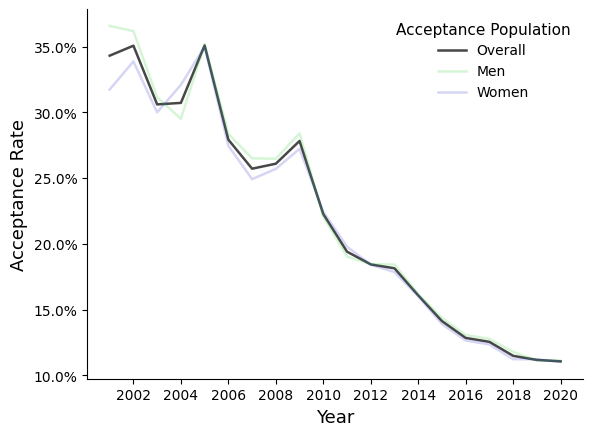

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

palette = {'Overall': (.2, .2, .2, .9),
           'Women': (.2, .2, .8, .2),
           'Men': (.2, .8, .2, .2)}

fig, ax = plt.subplots()

sns.lineplot(data=acceptance_melt, 
             x='year', 
             y='rate', 
             hue='acceptance_class',
             palette=palette,
             linewidth=1.8,
             ax=ax
            )

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine()

ax.set_xlabel('Year', size=13)
ax.set_ylabel('Acceptance Rate', size=13)
ax.legend(title='Acceptance Population',
           fontsize=10,
           title_fontsize=11,
           frameon=False)
plt.show()

### Display titles with acceptance rates

If we want to plot the titles, we need a shared y-axis attribute, in this case `acceptance_rate`. We need merge our acceptance rates into our `jhu_title_current` dataframe. We don't use our melted acceptance rate because we only need a single acceptance rate, per title.

In [57]:
jhu_title_acceptance = jhu_title_current.merge(
    acceptance_rates[['year', 'acceptance_rate']],
    on='year',
    how='left'
)

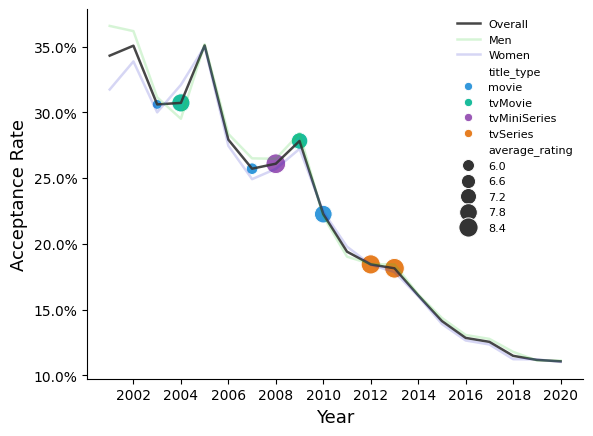

In [58]:

palette = {'Overall': (.2, .2, .2, .9),
           'Women': (.2, .2, .8, .2),
           'Men': (.2, .8, .2, .2)}

title_type_palette = {
    'movie': '#3498DB',        
    'tvSeries': '#E67E22',     
    'tvMiniSeries': '#9B59B6', 
    'tvMovie': '#1ABC9C'       
}

fig, ax = plt.subplots()

sns.lineplot(data=acceptance_melt, 
             x='year', 
             y='rate', 
             hue='acceptance_class',
             palette=palette,
             linewidth=1.8,
             ax=ax
            )

sns.scatterplot(data=jhu_title_acceptance,
                x='year', 
                y='acceptance_rate', 
                size='average_rating',
                hue='title_type',
                palette=title_type_palette,
                sizes=(50, 200),
                ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine()

ax.set_xlabel('Year', size=13)
ax.set_ylabel('Acceptance Rate', size=13)
ax.legend(fontsize=8, 
          title_fontsize=11,
          frameon=False)
plt.show()

It seems like there might be a (spurious) correlation between title type and acceptance rate. Let's take a look:

In [59]:
jhu_title_acceptance[['title_type', 'acceptance_rate']].groupby('title_type').mean()

,acceptance_rate
title_type,
movie,25.305102
tvMiniSeries,26.088775
tvMovie,29.267542
tvSeries,18.232469


We can plot each of the average acceptance rates, by title_type, as dotted lines:

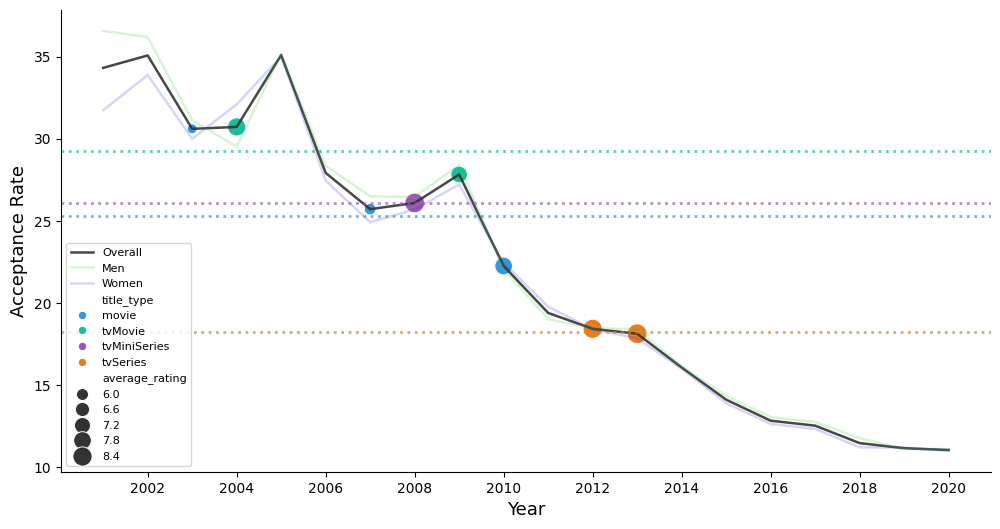

In [60]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator

palette = {'Overall': (.2, .2, .2, .9),
           'Women': (.2, .2, .8, .2),
           'Men': (.2, .8, .2, .2)}

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=acceptance_melt, 
             x='year', 
             y='rate', 
             hue='acceptance_class',
             palette=palette,
             linewidth=1.8,
             ax=ax
            )

sns.scatterplot(data=jhu_title_acceptance,
                x='year', 
                y='acceptance_rate', 
                size='average_rating',
                hue='title_type',
                palette=title_type_palette,
                sizes=(50, 200),
                ax=ax)

avg_by_type = jhu_title_acceptance[['title_type', 'acceptance_rate']].groupby('title_type').mean()

for title_type, row in avg_by_type.iterrows():
    color = title_type_palette[title_type] 
    ax.axhline(y=row['acceptance_rate'], 
                color=color, 
                linestyle=':', 
                linewidth=2,
                alpha=0.7)
    
ax.xaxis.set_major_locator(MultipleLocator(2))
sns.despine()

ax.set_xlabel('Year', size=13)
ax.set_ylabel('Acceptance Rate', size=13)
ax.legend(fontsize=8, 
          title_fontsize=11,
          frameon=True)
plt.show()

### Bonus: Display subplots based on the title genre

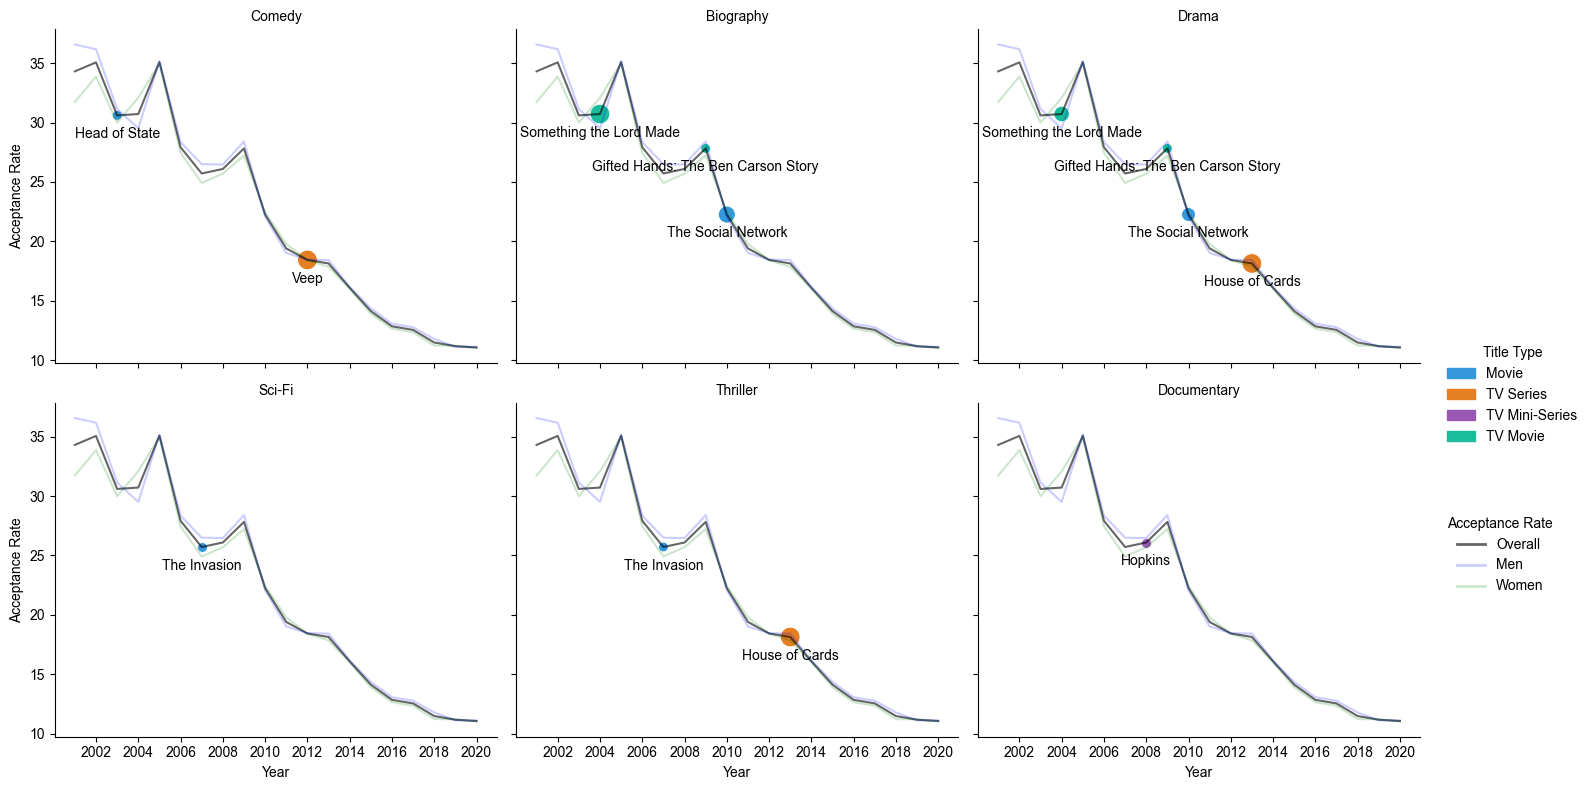

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Reset plot parameters
plt.rcdefaults()
sns.reset_orig()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']

title_type_palette = {
    'movie': '#3498DB',        
    'tvSeries': '#E67E22',     
    'tvMiniSeries': '#9B59B6', 
    'tvMovie': '#1ABC9C'       
}

g = sns.FacetGrid(data=jhu_title_acceptance, 
                  col='genre', 
                  col_wrap=3, 
                  height=4, 
                  aspect=1.2)

for ax in g.axes.flat:
    loc = plticker.MultipleLocator(base=2.0)
    ax.xaxis.set_major_locator(loc)
    sns.lineplot(data=acceptance_rates, 
                 x='year', 
                 y='acceptance_rate', 
                 color='black', 
                 alpha=0.6, 
                 ax=ax)
    sns.lineplot(data=acceptance_rates,
                 x='year', 
                 y='acceptance_rate_women', 
                 color='green', 
                 alpha=0.2, 
                 ax=ax)
    sns.lineplot(data=acceptance_rates, 
                 x='year',
                 y='acceptance_rate_men', 
                 color='blue', 
                 alpha=0.2, 
                 ax=ax)
g.map_dataframe(sns.scatterplot,
                x='year', 
                y='acceptance_rate', 
                size='average_rating',
                hue='title_type',
                palette=title_type_palette,
                sizes=(50, 200))

def add_labels(data, **kwargs):
    ax = plt.gca()
    for idx, row in data.iterrows():
        ax.text(row['year'], row['acceptance_rate'] - 1, row['title'], 
                fontsize=10, ha='center', va='top')
        
g.map_dataframe(add_labels)

label_mapping = {
    'movie': 'Movie',
    'tvSeries': 'TV Series',
    'tvMiniSeries': 'TV Mini-Series',
    'tvMovie': 'TV Movie'
}

title_handles = [mpatches.Patch(color=title_type_palette[key], label=label_mapping[key]) 
           for key in title_type_palette.keys()]

line_handles = [
    mlines.Line2D([], [], color='black', alpha=0.6, linewidth=2, label='Overall'),
    mlines.Line2D([], [], color='blue', alpha=0.2, linewidth=2, label='Men'),
    mlines.Line2D([], [], color='green', alpha=0.2, linewidth=2, label='Women')
]

g.fig.legend(handles=title_handles, 
             title='Title Type',
             bbox_to_anchor=(1.0, 0.5), 
             loc='center left',
             frameon=False)

g.fig.legend(handles=line_handles, 
                       title='Acceptance Rate',
                       bbox_to_anchor=(1.0, 0.3), 
                       loc='center left',
                       frameon=False)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Acceptance Rate")
plt.tight_layout()
plt.show()